<a href="https://colab.research.google.com/github/kayleecragg/kikibot/blob/main/Kikibot_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Welcome to Kikibot! 🤖**
Live Ops Shell-Lympics: https://plannertemplate.notion.site/Live-Ops-Champions-League-d55a01860b1a411db6929602d7992b0d?pvs=4

# **Setup (Initial): ⭐ ✨ 💾**

First when starting a new automation anything that interacts with Google Sheets, you need to add the tile-bot google account to the spreadsheet so that it can interact with the code.


Here’s the google account for first tilebot account:
tile-bot@tile-bot-405312.iam.gserviceaccount.com

Second tilebot account:
tilebot1@tilebot1.iam.gserviceaccount.com

In [ ]:
#@title Downloading JSON key from DROPBOX.

!wget 'https://www.dropbox.com/scl/fi/pn62ld9lasx7pql9stchk/tile-bot-405312-8bb4e65cbe47.json?rlkey=izjxkv7pygdtjkj0r494z16zg&dl=0'

In [ ]:
#@title Downloading JSON1 key from DROPBOX.

!wget 'https://www.dropbox.com/scl/fi/alhqrx0vp8q2qkt2n6wcj/tilebot1-a31d2f8e1c87.json?rlkey=070k79j0fkkkmrkrth0cgrzjx&st=yb4815n8&dl=0'

In [ ]:
#@title Installing/upgrading gspread libraries
!pip install gspread oauth2client
!pip install --upgrade gspread

# **Shells (Open this up!): 🐚**

**'*Tilebot* ' is the worksheet where you data entry, '*Day* ' is the worksheet where the shells will be generated. Rename them as you wish.**

**Input the correct data into the sheet like so:**
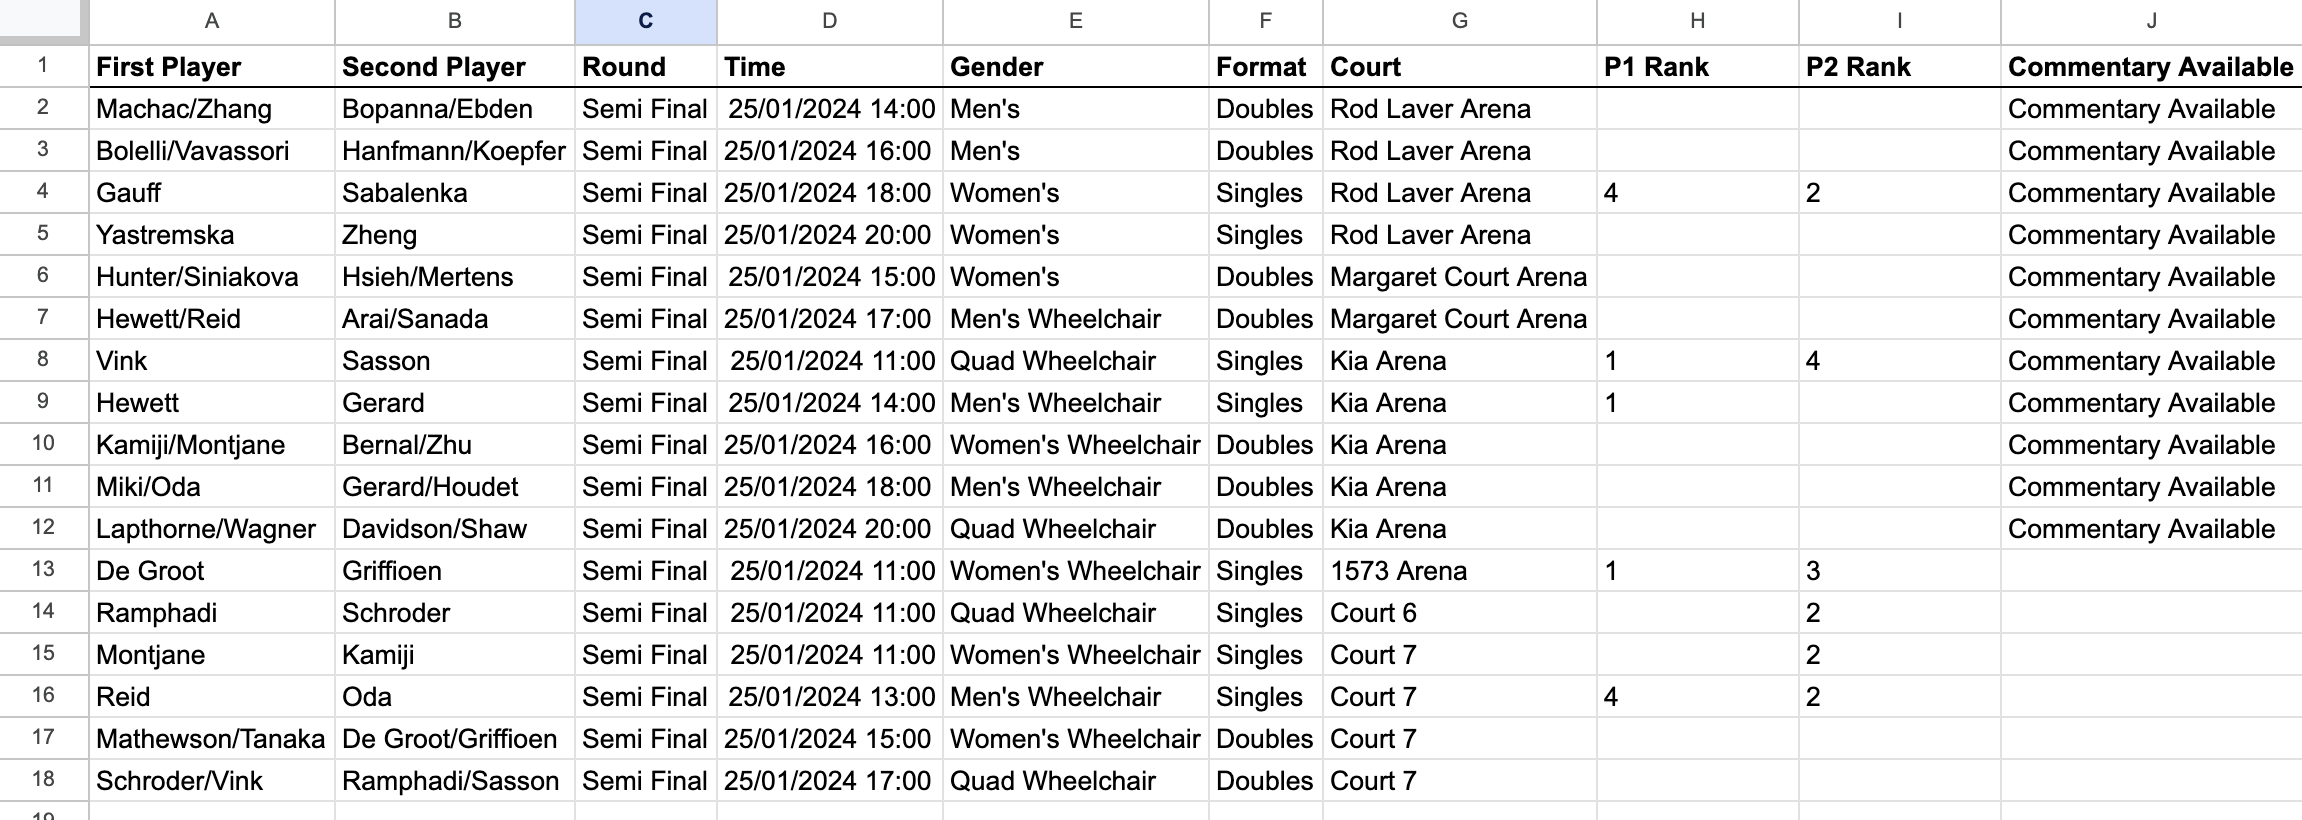

**When inputting times, you only need to input the times in for the first match of the court (for example, 11am start) and input the times for any matches that have 'before xyz time', like 'before 4:30pm' time - if it is a later time that what it would have been if that makes sense.**

In [ ]:
#@title Invoking Variables

credentials_file ='/content/tile-bot-405312-8bb4e65cbe47.json?rlkey=izjxkv7pygdtjkj0r494z16zg&dl=0' # @param ["/content/tile-bot-405312-8bb4e65cbe47.json?rlkey=izjxkv7pygdtjkj0r494z16zg&dl=0", "/content/tilebot1-a31d2f8e1c87.json?rlkey=070k79j0fkkkmrkrth0cgrzjx&st=yb4815n8&dl=0"]
sheet_id = '1mUh94nRbp9lt0m8VleYfl5UD0_O8iPOQNEHXh4_lnQk'  #@param {type:"string"}
template_sheet_id = sheet_id
template_worksheet_name = 'Roland Garros' # @param ["Australian Open", "Roland Garros", "Wimbledon", "US Open", "United Cup", "Brisbane International 2024", "Adelaide International"]
sheet_range = 'A1:AK1000'
source_worksheet_name = 'Data Template' #@param {type:"string"}
dest_worksheet_name = 'Day 1' #@param {type:"string"}

In [ ]:
#@title This will calculate the rest of the times that are missing from the data sheet

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta

def update_missing_match_times(sheet_id, source_worksheet_name, credentials_file):
    # Authenticate and create a client
    scope = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    client = gspread.authorize(creds)
    worksheet = client.open_by_key(sheet_id).worksheet(source_worksheet_name)

    # Read the data from the sheet
    try:
        data = worksheet.get_all_values()
        matches = data[1:]  # Assuming the first row is a header

        current_court = None
        current_time = None
        previous_match_type = None  # Track the type of the previous match

        for i, row in enumerate(matches):
            existing_time_str = row[3]  # Time information in Column D
            court = row[6]  # Court information in Column
            match_type_1 = row[4]  # Match type in Column E
            match_type_2 = row[5]  # Match type in Column F

            # Combine match types from both columns E and F
            match_type = f"{match_type_1} {match_type_2}"

            if existing_time_str.strip():
                # If there is an existing time, parse it and use it as the current time
                current_time = datetime.strptime(existing_time_str, '%d/%m/%Y %H:%M')
            else:
                # Skip if current_time is not set (i.e., no previous match time to base on)
                if not current_time:
                    continue

                # Calculate the match time based on the gender information
                duration = timedelta(hours=3) if previous_match_type == "Men's Singles" else timedelta(hours=2)
                current_time += duration

                # Format the date-time in an ISO format recognized by Google Sheets
                iso_formatted_time = current_time.strftime('%d/%m/%Y %H:%M')

                # Update the sheet with new value for this row
                worksheet.update(f'D{i + 2}', [[iso_formatted_time]])  # i + 2 to write to the correct row

            # Update court and previous match type for next iteration
            current_court = court
            previous_match_type = match_type

        # Apply the desired date format to the column
        date_format = {"numberFormat": {"type": "DATE_TIME", "pattern": "dd/MM/yyyy HH:mm"}}
        worksheet.format('B2:B' + str(len(matches) + 1), date_format)

        print("Missing match times updated successfully.")
    except Exception as e:
        print(f"Error processing sheet: {e}")

# Example call to the function (replace with actual values)
update_missing_match_times(sheet_id, source_worksheet_name, credentials_file)

In [ ]:
#@title Setting up initial Day from template

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build


def copy_sheet_data_with_full_formatting(template_sheet_id, template_worksheet_name, sheet_id, dest_worksheet_name, credentials_file):
    # Authenticate and create a client
    scope = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    client = gspread.authorize(creds)

    # Build the Google Sheets API service
    service = build('sheets', 'v4', credentials=creds)

    # Open the source and destination Google Sheets
    try:
        source_sheet = client.open_by_key(template_sheet_id)
        dest_sheet = client.open_by_key(sheet_id)
    except Exception as e:
        print(f"Error opening sheets: {e}")
        return

    # Check if the destination worksheet exists, create if not
    try:
        dest_worksheet = None
        try:
            dest_worksheet = dest_sheet.worksheet(dest_worksheet_name)
        except gspread.WorksheetNotFound:
            # Create a new worksheet
            dest_sheet.add_worksheet(title=dest_worksheet_name, rows="1000", cols="26")  # Adjust rows and columns as needed
            dest_worksheet = dest_sheet.worksheet(dest_worksheet_name)

        source_worksheet = source_sheet.worksheet(template_worksheet_name)
    except Exception as e:
        print(f"Error accessing or creating worksheets: {e}")
        return

    try:
        # Get the detailed data from the source sheet
        source_range = f'{source_worksheet.title}!{sheet_range}'
        request = service.spreadsheets().get(spreadsheetId=template_sheet_id, ranges=[source_range], includeGridData=True)
        source_data = request.execute()

        # Extract data for updating the destination sheet
        rows = source_data['sheets'][0]['data'][0].get('rowData', [])
        data = []
        for row in rows:
            row_data = []
            for cell in row.get('values', []):
                # Handle different types of values including formulas
                if 'userEnteredValue' in cell:
                    cell_value = cell['userEnteredValue']
                    if 'formulaValue' in cell_value:
                        row_data.append(cell_value['formulaValue'])
                    elif 'stringValue' in cell_value:
                        row_data.append(cell_value['stringValue'])
                    elif 'numberValue' in cell_value:
                        row_data.append(cell_value['numberValue'])
                    elif 'boolValue' in cell_value:
                        row_data.append(cell_value['boolValue'])
                    else:
                        row_data.append('')
                else:
                    row_data.append('')
            data.append(row_data)

        # Extract data validation rules
        validation_rules = []
        rows = source_data['sheets'][0]['data'][0].get('rowData', [])
        for i, row in enumerate(rows):
            for j, cell in enumerate(row.get('values', [])):
                if 'dataValidation' in cell:
                    rule = cell['dataValidation']
                    validation_rules.append({
                        'range': {
                            'sheetId': dest_worksheet.id,
                            'startRowIndex': i,
                            'endRowIndex': i + 1,
                            'startColumnIndex': j,
                            'endColumnIndex': j + 1
                        },
                        'rule': rule
                    })

        # Write values and formulas to the destination sheet
        dest_range = f'{dest_worksheet.title}!{sheet_range}'
        body = {'values': data}
        service.spreadsheets().values().update(
            spreadsheetId=sheet_id, range=dest_range,
            valueInputOption='USER_ENTERED', body=body).execute()

        # Apply data validation rules to the destination sheet
        if validation_rules:
            requests = [{'setDataValidation': {'range': rule['range'], 'rule': rule['rule']}} for rule in validation_rules]
            service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body={'requests': requests}).execute()


        # Copy formatting
        format_requests = {
            'requests': [{
                'copyPaste': {
                    'source': {
                        'sheetId': source_worksheet.id,
                        'startRowIndex': 0,
                        'endRowIndex': len(rows),
                        'startColumnIndex': 0,
                        'endColumnIndex': 37,  # Assuming 26 columns (A to Z)
                    },
                    'destination': {
                        'sheetId': dest_worksheet.id,
                        'startRowIndex': 0,
                        'endRowIndex': len(rows),
                        'startColumnIndex': 0,
                        'endColumnIndex': 37,
                    },
                    'pasteType': 'PASTE_FORMAT',
                    'pasteOrientation': 'NORMAL'
                }
            }]
        }

        service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body=format_requests).execute()

        print(f"Data, formulas, formatting, and data validation rules copied successfully.")
    except Exception as e:
        print(f"Error during data and format copying: {e}")

copy_sheet_data_with_full_formatting(template_sheet_id, template_worksheet_name, sheet_id, dest_worksheet_name, credentials_file)

**Remember, if you name your Data Sheet something other than 'Data Template', change it in your Shell sheet BEFORE you proceed with the next steps**

In [ ]:
#@title Copying over from match template based on amount of matches

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build
import re
import time


# Example usage
def adjust_formula(formula, row_offset, current_row, reference_row, same_row_columns, section_size=5):
    """
    Adjust the row references in a formula by a specific offset.
    For specific rows and columns, the formulas will reference different rows based on the logic provided.
    """
    cell_ref_regex = r'([A-Z\$]+)(\d+)'

    def adjust_match(match):
        col_ref = match.group(1)  # Column reference
        row_ref = int(match.group(2))  # Row reference
        if '$' not in col_ref:  # Skip absolute row references
            if col_ref in same_row_columns and (current_row - reference_row) % section_size == 0:
                # For specified columns in the first row of each section, reference the same row
                adjusted_row_ref = current_row
            elif col_ref in same_row_columns:
                # For specified columns in other rows, reference the first row of the section
                adjusted_row_ref = current_row - ((current_row - reference_row) % section_size)
            else:
                # For other columns, adjust normally
                adjusted_row_ref = row_ref + row_offset
            return f'{col_ref}{adjusted_row_ref}'
        else:
            return f'{col_ref}{row_ref}'

    adjusted_formula = re.sub(cell_ref_regex, adjust_match, formula)
    return adjusted_formula

def replicate_formatting(sheet_id, dest_worksheet_name, credentials_file):
    # Authenticate and create a client
    scope = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    client = gspread.authorize(creds)

    # Build the Google Sheets API service
    service = build('sheets', 'v4', credentials=creds)

    # Open the destination Google Sheet
    try:
        dest_sheet = client.open_by_key(sheet_id)
        dest_worksheet = dest_sheet.worksheet(dest_worksheet_name)
    except Exception as e:
        print(f"Error opening sheet: {e}")
        return

    # Define the range to copy (rows 8-11)
    copy_range = 'A8:AK11'

    # Determine the number of rows to replicate based on 'Data 1' sheet
    data_sheet = client.open_by_key(sheet_id).worksheet(source_worksheet_name)
    data_rows = len(data_sheet.get_all_values())
    rows_to_replicate = data_rows - 3

    # Get the detailed data from the range to copy, including data validation rules
    request = service.spreadsheets().get(spreadsheetId=sheet_id, ranges=[f'{dest_worksheet.title}!{copy_range}'], includeGridData=True)
    source_data = request.execute()

    # Extract data, formulas, formats, and data validation rules for updating the destination sheet
    source_rows = source_data['sheets'][0]['data'][0].get('rowData', [])
    source_data_list = []
    data_validation_rules = []
    for row_index, row in enumerate(source_rows):
        row_data = []
        row_rules = []
        for cell_index, cell in enumerate(row.get('values', [])):
            # Data extraction
            if 'userEnteredValue' in cell:
                cell_value = cell['userEnteredValue']
                if 'formulaValue' in cell_value:
                    row_data.append(cell_value['formulaValue'])
                elif 'stringValue' in cell_value:
                    row_data.append(cell_value['stringValue'])
                elif 'numberValue' in cell_value:
                    row_data.append(cell_value['numberValue'])
                elif 'boolValue' in cell_value:
                    row_data.append(cell_value['boolValue'])
                else:
                    row_data.append('')
            else:
                row_data.append('')

            # Data validation rule extraction
            if 'dataValidation' in cell:
                rule = cell['dataValidation']
                row_rules.append((row_index, cell_index, rule))
        source_data_list.append(row_data)
        data_validation_rules.extend(row_rules)

    # Replicate the formatting, data, and data validation rules with gaps
    original_row_count = 4  # Number of rows in the source range (8-11)
    start_row = 12  # Start copying from row 13, leaving a gap after row 11
    same_row_columns = {'B','C','E','F','H','K','L','W','X','Y','Z','AC','AE','AG','AA','aa'}  # Columns that should always reference the same row

    for i in range(rows_to_replicate):
        row_offset = (original_row_count + 1) * i  # Calculate the offset for this replication
        reference_row = start_row + 1  # The first row of the current section

        # Data and formula adjustment
        adjusted_data_list = []
        for row_index, row in enumerate(source_data_list):
            current_row = start_row + row_index + 1  # Calculate the current row
            adjusted_row = []
            for cell in row:
                if isinstance(cell, str) and cell.startswith('='):  # Check if it's a formula
                    adjusted_row.append(adjust_formula(cell, row_offset, current_row, reference_row, same_row_columns))
                else:
                    adjusted_row.append(cell)
            adjusted_data_list.append(adjusted_row)

        # Update values and formulas
        dest_range = f'{dest_worksheet.title}!A{start_row + 1}:AK{start_row + 4}'
        body = {'values': adjusted_data_list}
        service.spreadsheets().values().update(
            spreadsheetId=sheet_id, range=dest_range,
            valueInputOption='USER_ENTERED', body=body).execute()

        # Copy formatting
        format_requests = {
            'requests': [{
                'copyPaste': {
                    'source': {
                        'sheetId': dest_worksheet.id,
                        'startRowIndex': 7,
                        'endRowIndex': 11,
                        'startColumnIndex': 0,
                        'endColumnIndex': 37,  # Including column AK
                    },
                    'destination': {
                        'sheetId': dest_worksheet.id,
                        'startRowIndex': start_row,
                        'endRowIndex': start_row + 4,
                        'startColumnIndex': 0,
                        'endColumnIndex': 37,
                    },
                    'pasteType': 'PASTE_FORMAT',
                    'pasteOrientation': 'NORMAL'
                }
            }]
        }
        service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body=format_requests).execute()

        # Apply data validation rules
        for rule_index, (src_row, src_col, rule) in enumerate(data_validation_rules):
            rule_request = {
                'setDataValidation': {
                    'range': {
                        'sheetId': dest_worksheet.id,
                        'startRowIndex': start_row + src_row,
                        'endRowIndex': start_row + src_row + 1,
                        'startColumnIndex': src_col,
                        'endColumnIndex': src_col + 1,
                    },
                    'rule': rule
                }
            }
            time.sleep(2)
            service.spreadsheets().batchUpdate(spreadsheetId=sheet_id, body={'requests': [rule_request]}).execute()

        # Update the starting row for the next replication
        start_row += 5  # 4 rows of data plus 1 row gap

    print(f"Formats, data, and data validation rules replicated successfully for {rows_to_replicate} sections.")

# Call the function
replicate_formatting(sheet_id, dest_worksheet_name, credentials_file)


In [ ]:
 #@title Copying over match data from data sheet

import gspread
from oauth2client.service_account import ServiceAccountCredentials
from googleapiclient.discovery import build

def transfer_data(sheet_id, credentials_file):
    # Authenticate and create a client
    scope = ["https://www.googleapis.com/auth/spreadsheets", "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(credentials_file, scope)
    client = gspread.authorize(creds)

    # Open the destination Google Sheet
    try:
        dest_sheet = client.open_by_key(sheet_id)
        data_worksheet = dest_sheet.worksheet(source_worksheet_name)
        day_worksheet = dest_sheet.worksheet(dest_worksheet_name)
    except Exception as e:
        print(f"Error opening sheet: {e}")
        return

    # Define the columns to transfer and their destination columns
    columns_to_transfer = {
        4: 'AB',  # D2 onwards to AB3 onwards - time
        1: 'AC',  # A2 onwards to AC3 onwards - player 1
        2: 'AE',  # B2 onwards to AE3 onwards - player 2
        3: 'Z',   # C2 onwards to Z3 onwards - round
        6: 'AG'   # F2 onwards to AG3 onwards - court
    }

    for source_col, dest_col_prefix in columns_to_transfer.items():
        # Get all values from the source column starting from row 2
        values = data_worksheet.col_values(source_col)[1:]  # Skip the first row (title)

        # Loop through the values
        for i, value in enumerate(values, start=1):
            # Calculate the destination row using the formula
            dest_row = 3 + (i - 1) * 5

            # Write the value to the calculated cell in 'Day 1'
            time.sleep(1)
            day_worksheet.update_acell(f'{dest_col_prefix}{dest_row}', value)
        print(f"Data from column {source_col} transferred to column {dest_col_prefix} for {len(values)} rows.")

# Call the function
transfer_data(sheet_id, credentials_file)


# **Tennis Pre-Images:**

## **Setup (selenium):**

In [ ]:
#@title Installing Selenium

# Set up for running selenium in Google Colab
## You don't need to run this code if you do it in Jupyter notebook, or other local Python setting
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium
pip install webdriver-manager

In [ ]:
#@title Downloading Flags folder from Dropbox

!wget -O Flags.zip "https://www.dropbox.com/scl/fo/z2ao7680uo1avlxry68zg/h?rlkey=0yr70n4b7v3ol37jyhmbfflnh&dl=0"
!mkdir -p Flags
!unzip Flags.zip -d Flags
!rm Flags.zip

In [ ]:
#@title Downloading Logos folder from Dropbox

!wget -O Logos.zip "https://www.dropbox.com/scl/fo/17v400uls31pak9vm2rqp/h?rlkey=socex8uazv4fy62xnq64nmosk&st=bne6atoc&dl=0"
!mkdir -p Logos
!unzip Logos.zip -d Logos
!rm Logos.zip

## **Image container**

**Change the range name from 'Data Template' to whatever your data sheet is called.**

**If you see an error that says module selenium is not found, remember to run Setup (Selenium)!**

In [ ]:
#@title **Tennis Prepromotes (COMMENTARY)**

import os
import time
import zipfile
import subprocess
import shutil
from google.colab import files
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException, WebDriverException, NoSuchElementException, ElementClickInterceptedException
from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials

folder_name = 'Prepromotes'
os.makedirs(folder_name, exist_ok=True)
download_default_directory = f'/content/{folder_name}'

#logos image input
logos_base_path = '/content/Flags'

# Google Sheets API setup
creds = Credentials.from_service_account_file(credentials_file)
service = build('sheets', 'v4', credentials=creds)

# Your Google Sheet ID and the range of cells to access
SPREADSHEET_ID = sheet_id
RANGE_NAME = 'Data Template!A2:N200' #@param {type:"string"}
tennis = 'US Open' # @param ["Australian Open", "Roland Garros", "Wimbledon", "US Open", "United Cup", "Brisbane International 2024", "Adelaide International"]

live_and_upcoming = True # @param {type:"boolean"}
prematch_logo_card = False # @param {type:"boolean"}
postmatch_logo_card = True # @param {type:"boolean"}


# Set up headless Chrome options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_experimental_option("prefs", {
  "download.default_directory": f'/content/{folder_name}',
  "download.prompt_for_download": False,
  "download.directory_upgrade": True,
  "safebrowsing.enabled": True
})

# Call the Sheets API to read data
sheet_service = service.spreadsheets()
result = sheet_service.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Function to clear input field
def clear_input_field(element):
    # Clear using Selenium's clear method
    element.clear()
    # If the element is not cleared, use JavaScript to clear it
    browser.execute_script("arguments[0].value = '';", element)
    # Check and retry if the input is not cleared
    for i in range(3):
        if element.get_attribute('value'):
            element.clear()
            browser.execute_script("arguments[0].value = '';", element)
            time.sleep(1)
        else:
            break

def wait_for_download_complete(download_directory, timeout=300):
    start_time = time.time()
    while True:
        # Find the most recent zip file in the directory
        zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')],
                           key=lambda f: os.path.getctime(os.path.join(download_directory, f)),
                           reverse=True)

        if zip_files:
            latest_zip = os.path.join(download_directory, zip_files[0])
            initial_size = os.path.getsize(latest_zip)

            # Wait for a short period to check if the file is still being written to
            time.sleep(1)
            if os.path.getsize(latest_zip) == initial_size:
                # If file size hasn't changed, assume download is complete
                return latest_zip

        # Check for timeout
        if (time.time() - start_time) > timeout:
            raise Exception("Timeout: File download did not complete within the specified time.")

        time.sleep(1)  # Check every 1 second

# Create a browser instance with headless Chrome
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
browser.set_window_size(1920, 1080)

# Process and iterate over Google Sheets data
if not values:
    print('No data found.')
else:
    for row in values:
        # Ensure row has enough elements
        row += [None] * (14 - len(row))

        # Unpack the row into variables
        input1_value, input2_value, round_value, datetime_value, gender_value, sd_value, court_value, rank1_value, rank2_value, event_data, countries1_value, countries2_value, firstname1_value, firstname2_value = row

        if input1_value is None:  # Check for end of data
            break

        browser.get('https://thelivecms.prod.streamco.cloud/tile-creator/')
            # live & upcoming

        if live_and_upcoming:
          live = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Live & Upcoming')]")
              )
          )
          live.click();

        # home & away
        if live_and_upcoming:
          home = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Home v Away (tennis, combat, football, etc)')]")
              )
          )
          home.click()

        # logo cards

        logo = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.XPATH,  "//*[contains(text(), 'Logo Cards')]")
            )
        )
        logo.click();

        # prematch logo card
        if prematch_logo_card:
          pre = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Logo Card Prematch')]")
              )
          )
          pre.click()

        # postmatch logo card
        if postmatch_logo_card:
          post = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Logo Card Postmatch')]")
              )
          )
          post.click()

        # select sport + competition

        select1 = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.ID, "select-sport-type-id")
            )
        )
        select1 = Select(select1)
        select1.select_by_visible_text('Tennis')

        select2 = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.ID, "select-competition-id")
            )
        )
        select2 = Select(select2)

        # Implementing the conditional logic
        if tennis == 'Australian Open':
            if sd_value == 'Singles':
                select2.select_by_visible_text('TENNIS: Australian Open Singles')
            else:
                select2.select_by_visible_text('TENNIS: Australian Open Extra Comps')
        if tennis == 'Roland Garros':
            if sd_value == 'Singles':
                select2.select_by_visible_text('TENNIS: Roland Garros Singles')
            else:
                select2.select_by_visible_text('TENNIS: Roland Garros Doubles')
        if tennis == 'Wimbledon':
            if sd_value == 'Singles':
                select2.select_by_visible_text('TENNIS: Wimbledon Singles')
            else:
                select2.select_by_visible_text('TENNIS: Wimbledon Doubles')

        # You can add more conditions for other tennis values
        # elif:
        #     selection_text = f'TENNIS: {tennis}'
        #     select2.select_by_visible_text(selection_text)

        # Enabling 4 players
        if sd_value == 'Doubles':
            fourplayers_checkbox = WebDriverWait(browser, 2, 0.2).until(
                EC.element_to_be_clickable(
                    (By.XPATH,  "//label[text()='4 Players']/preceding-sibling::input")
                )
            )
            fourplayers_checkbox.click()

        # Inputting the first name no.1

        if sd_value == 'Singles':
            firstname1 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.XPATH, "//label[contains(text(), 'Opponent #1 Small text')]/following-sibling::input[@type='text']")
                )
            )
            clear_input_field(firstname1)
            time.sleep(2)

            firstname1 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.XPATH, "//label[contains(text(), 'Opponent #1 Small text')]/following-sibling::input[@type='text']")
                )
            )
            firstname1.send_keys(firstname1_value)

            # Inputting the first name no.2

            firstname2 = browser.find_element(By.XPATH, "//label[contains(text(), 'Opponent #2 Small text')]/following-sibling::input[@type='text']")
            clear_input_field(firstname2)
            time.sleep(2)
            firstname2.send_keys(firstname2_value)


        if '/' in input1_value:
            # Split the string into two parts at the slash
            name1_value, name2_value = input1_value.split('/')

            # name 1

            name1 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='home1']")
                )
            )
            clear_input_field(name1)
            time.sleep(2)

            name1 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='home1']")
                )
            )
            name1.send_keys(name1_value)

            # name 2
            name2 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='home2']")
                )
            )
            clear_input_field(name2)

            name2 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='home2']")
                )
            )
            name2.send_keys(name2_value)

            # Now name1 and name2 hold the separate names
            # You can use name1 and name2 as needed in your code
        else:
            input1 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.ID, "downshift-0-input")
                )
            )
            clear_input_field(input1)
            time.sleep(2)


            input1 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.ID, "downshift-0-input")
                )
            )
            input1.send_keys(input1_value)

            # team 2

            input2 = browser.find_element(By.ID,"downshift-1-input")
            clear_input_field(input2)
            time.sleep(2)
            input2.send_keys(input2_value)


        if '/' in input2_value:
            # Split the string into two parts at the slash
            name3_value, name4_value = input2_value.split('/')

            name3 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='away1']")
                )
            )
            clear_input_field(name3)

            name3 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='away1']")
                )
            )
            name3.send_keys(name3_value)

            name4 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='away2']")
                )
            )
            clear_input_field(name4)

            name4 = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[value='away2']")
                )
            )
            name4.send_keys(name4_value)

        # rank 1

        if sd_value == 'Singles':
            if rank1_value:  # This will be False if rank1_value is blank or None
                rank1 = WebDriverWait(browser, 10, 0.2).until(
                    EC.element_to_be_clickable(
                        (By.XPATH, "//label[contains(text(), 'Opponent #1 Rank')]/following-sibling::input[@type='text']")
                    )
                )
                rank1.send_keys(rank1_value)

        # rank 2
        if sd_value == 'Singles':
            if rank2_value:  # This will be False if rank1_value is blank or None
                rank2 = WebDriverWait(browser, 10, 0.2).until(
                    EC.element_to_be_clickable(
                        (By.XPATH, "//label[contains(text(), 'Opponent #2 Rank')]/following-sibling::input[@type='text']")
                    )
                )
                rank2.send_keys(rank2_value)

        # rank2 = browser.find_element(By.XPATH, "//label[contains(text(), 'Opponent #2 Rank')]/following-sibling::input[@type='text']")
        # clear_input_field(rank2)
        # rank2.send_keys(rank2_value)

        if '/' in countries1_value:
            # Split the string into two parts at the slash
            country1_value, country2_value = countries1_value.split('/')

            # opponent 1A flag
            file_input_opponent1A = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located(
                    (By.XPATH, "//label[contains(text(), 'Opponent #1A Flag')]/following-sibling::input[@type='file']")
                )
            )
            file_path_opponent1A = os.path.join(logos_base_path, f"{country1_value}.png")
            file_input_opponent1A.send_keys(file_path_opponent1A)

            # opponent 1B flag
            file_input_opponent1B = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located(
                    (By.XPATH, "//label[contains(text(), 'Opponent #1B Flag')]/following-sibling::input[@type='file']")
                )
            )
            file_path_opponent1B = os.path.join(logos_base_path, f"{country2_value}.png")
            file_input_opponent1B.send_keys(file_path_opponent1B)


        else:
            # opponent 1 flag
            file_input_opponent1 = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located(
                    (By.XPATH, "//label[contains(text(), 'Opponent #1 Flag')]/following-sibling::input[@type='file']")
                )
            )
            file_path_opponent1 = os.path.join(logos_base_path, f"{countries1_value}.png")
            file_input_opponent1.send_keys(file_path_opponent1)

            # opponent 2 flag
            file_input_opponent2 = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located(
                    (By.XPATH, "//label[contains(text(), 'Opponent #2 Flag')]/following-sibling::input[@type='file']")
                )
            )
            file_path_opponent2 = os.path.join(logos_base_path, f"{countries2_value}.png")
            file_input_opponent2.send_keys(file_path_opponent2)

        if '/' in countries2_value:
            # Split the string into two parts at the slash
            country3_value, country4_value = countries2_value.split('/')

            # opponent 2A flag
            file_input_opponent2A = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located(
                    (By.XPATH, "//label[contains(text(), 'Opponent #2A Flag')]/following-sibling::input[@type='file']")
                )
            )
            file_path_opponent2A = os.path.join(logos_base_path, f"{country3_value}.png")
            file_input_opponent2A.send_keys(file_path_opponent2A)

            # opponent 2B flag
            file_input_opponent2B = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located(
                    (By.XPATH, "//label[contains(text(), 'Opponent #2B Flag')]/following-sibling::input[@type='file']")
                )
            )
            file_path_opponent2B = os.path.join(logos_base_path, f"{country4_value}.png")
            file_input_opponent2B.send_keys(file_path_opponent2B)


        # delete event long

        event_long = WebDriverWait(browser, 10, 0.2).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "input[value='Event Long']")
            )
        )
        clear_input_field(event_long)

        # if event_data:  # Check if event_data is not empty
        #     event_long.send_keys(event_data)
        # else:  # If event_data is empty or None
        #     event_long.send_keys(" ")

        if sd_value == 'Singles':
            if event_data:  # Check if event_data is not empty
                event_long.send_keys(event_data)
            else:  # If event_data is empty or None
                event_long.send_keys(" ")

        elif sd_value == 'Doubles':
            if event_data:  # Check if event_data is not empty
                event_long.send_keys(event_data)
            else:  # If event_data is empty or None
                event_long.send_keys(f"{gender_value} {sd_value}")

        # date (e.g Nov 6)
        # Example string, replace with your actual date string format
        datetime_str = datetime_value  # Assuming the format is something like 'YYYY-MM-DD'

        # Convert the string to a datetime object
        datetime_obj = datetime.strptime(datetime_str, '%d/%m/%Y %H:%M')


        if postmatch_logo_card:
          date_input = WebDriverWait(browser, 10).until(
              EC.element_to_be_clickable(
                  (By.XPATH, "//input[@placeholder='competition date']")
              )
          )
          date_input = WebDriverWait(browser, 10).until(
              EC.element_to_be_clickable((By.XPATH, "//input[@placeholder='competition date']"))
          )
          clear_input_field(date_input)
          desired_date = datetime_obj.strftime('%b %-d')
          date_input.send_keys(desired_date)

        # round

        round_textarea = WebDriverWait(browser, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//label[contains(text(), 'Round')]/following-sibling::textarea"))
        )
        clear_input_field(round_textarea)
        # round_textarea.send_keys(f"{round_value}")
        # if sd_value == 'Doubles':
        #     round_textarea.send_keys(f"{gender_value} {sd_value} {round_value}")
        # else:
        #     round_textarea.send_keys(f"{gender_value} {round_value}")
        if sd_value == 'Doubles':
            if event_data:  # Check if event_data is not empty
                round_textarea.send_keys(f"{gender_value} {sd_value} {round_value}")
            else:  # If event_data is empty or None
                round_textarea.send_keys(f"{round_value}")
        else:
            round_textarea.send_keys(f"{gender_value} {round_value}")

        # comp - flag

        # select4 = WebDriverWait(browser, 2, 0.2).until(
        #     EC.presence_of_element_located(
        #         (By.ID, "select-special-carousel-logo-id")
        #     )
        # )
        # select4 = Select(select4)
        # select4.select_by_visible_text('TENNIS: US Open Extras')
        if postmatch_logo_card:
          select4_input = WebDriverWait(browser, 10).until(
              EC.presence_of_element_located(
                  (By.XPATH, "//label[contains(text(), 'Carousel Logo')]/following-sibling::input[@type='file']")
              )
          )
          # Mapping the competition names to file paths
          file_paths = {
              "Australian Open": '/content/Logos/Australian Open.png',
              "Roland Garros": '/content/Logos/Roland Garros.png',
              "Wimbledon": '/content/Logos/Wimbledon.png',
              "US Open": '/content/Logos/US Open.png',
              "United Cup": '/content/Logos/United Cup.png',
              "Brisbane International 2024": '/content/Logos/Brisbane International.png',
              "Adelaide International": '/content/Logos/Adelaide International.png'
          }
          select4_path = file_paths[tennis]
          select4_input.send_keys(select4_path)

        time.sleep(2)

        # downloading

        try:
            # Wait for the button to be clickable by both class and text, with a timeout of 10 seconds
            save_as_zip_button = WebDriverWait(browser, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'btn-warning') and contains(text(), 'Save as .zip')]"))
            )
            time.sleep(5)

            # Instead of clicking the button with Selenium's click function, we use JavaScript to click
            browser.execute_script("arguments[0].click();", save_as_zip_button)
            print("Button clicked successfully via JavaScript.")
        except TimeoutException:
            print("Button was not found within the given time.")
        except NoSuchElementException:
            print("Button could not be found.")
        except Exception as e:
            print(f"An error occurred: {e}")
        download_directory = download_default_directory
        try:
            downloaded_file = wait_for_download_complete(download_directory)
            print(f"Download complete: {downloaded_file}")
        except Exception as e:
            print(str(e))

        zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')], key=lambda f: os.path.getctime(os.path.join(download_directory, f)), reverse=True)

        if sd_value == 'Singles':
            if zip_files:
                zip_file_name = zip_files[0]
                zip_file_path = os.path.join(download_directory, zip_file_name)

                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall(download_directory)
                    extracted_files = zip_ref.namelist()

                if extracted_files:
                    new_singles_folder_path = os.path.join(download_directory, f"{input1_value} v {input2_value} {gender_value} {sd_value}")
                    if not os.path.exists(new_singles_folder_path):
                        os.mkdir(new_singles_folder_path)

                    print(f"Moving files to {new_singles_folder_path}")

                    for file in extracted_files:
                        original_file_path = os.path.join(download_directory, file)
                        new_file_path = os.path.join(new_singles_folder_path, file)
                        # print(f"Moving {original_file_path} to {new_file_path}")
                        shutil.move(original_file_path, new_file_path)

                    subprocess.run(["open", "-R", new_singles_folder_path])

                else:
                    print("No files found in the zip.")
            else:
                print("No zip files found in the download directory.")

            os.remove(zip_file_path)
        else:
            name1_value, name2_value = input1_value.split('/')
            name3_value, name4_value = input2_value.split('/')
            if zip_files:
                zip_file_name = zip_files[0]
                zip_file_path = os.path.join(download_directory, zip_file_name)

                with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                    zip_ref.extractall(download_directory)
                    extracted_files = zip_ref.namelist()

                if extracted_files:
                    new_doubles_folder_path = os.path.join(download_directory, f"{name1_value} v {name3_value} {sd_value}")
                    if not os.path.exists(new_doubles_folder_path):
                        os.mkdir(new_doubles_folder_path)

                    print(f"Moving files to {new_doubles_folder_path}")

                    for file in extracted_files:
                        original_file_path = os.path.join(download_directory, file)
                        new_file_path = os.path.join(new_doubles_folder_path, file)
                        # print(f"Moving {original_file_path} to {new_file_path}")
                        shutil.move(original_file_path, new_file_path)

                    subprocess.run(["open", "-R", new_doubles_folder_path])

                else:
                    print("No files found in the zip.")
            else:
                print("No zip files found in the download directory.")

            os.remove(zip_file_path)


        # For Australian Open, process the second iteration with "RAIN DELAY"
        if tennis == 'Australian Open' or tennis == 'Roland Garros' or tennis == 'Wimbledon':
            rain_delay_input = WebDriverWait(browser, 10, 0.2).until(
                EC.element_to_be_clickable(
                    (By.CSS_SELECTOR, "input[placeholder='rain delay']")
                )
            )
            clear_input_field(rain_delay_input)  # Assuming you have a function to clear the input field
            rain_delay_input.send_keys("RAIN DELAY")

            try:
                # Wait for the button to be clickable by both class and text, with a timeout of 10 seconds
                save_as_zip_button = WebDriverWait(browser, 10).until(
                    EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'btn-warning') and contains(text(), 'Save as .zip')]"))
                )
                time.sleep(5)

                # Instead of clicking the button with Selenium's click function, we use JavaScript to click
                browser.execute_script("arguments[0].click();", save_as_zip_button)
                print("Button clicked successfully via JavaScript.")
            except TimeoutException:
                print("Button was not found within the given time.")
            except NoSuchElementException:
                print("Button could not be found.")
            except Exception as e:
                print(f"An error occurred: {e}")
            download_directory = download_default_directory
            try:
                downloaded_file = wait_for_download_complete(download_directory)
                print(f"Download complete: {downloaded_file}")
            except Exception as e:
                print(str(e))

            zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')], key=lambda f: os.path.getctime(os.path.join(download_directory, f)), reverse=True)
            if zip_files:
              zip_file_name = zip_files[0]
              zip_file_path = os.path.join(download_directory, zip_file_name)

              # Verify the zip file before attempting to extract
              if os.path.isfile(zip_file_path) and os.path.getsize(zip_file_path) > 0:
                  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                      try:
                          zip_ref.extractall(download_directory)
                          extracted_files = zip_ref.namelist()
                          print(f"Extracted files: {extracted_files}")
                      except zipfile.BadZipFile:
                          print(f"Failed to extract {zip_file_path}: The file may be corrupted.")
                      except Exception as e:
                          print(f"An unexpected error occurred while extracting {zip_file_path}: {e}")
              else:
                  print(f"The zip file {zip_file_path} does not exist or is empty.")

            if sd_value == 'Singles':
                folder_path = new_singles_folder_path
            else:
                folder_path = new_doubles_folder_path

            # Create a "Rain Delay" subfolder inside the existing folder
            rain_delay_folder_path = os.path.join(folder_path, "Rain Delay")
            if not os.path.exists(rain_delay_folder_path):
                os.mkdir(rain_delay_folder_path)

            # Move files to the "Rain Delay" subfolder
            for file in extracted_files:
                original_file_path = os.path.join(download_directory, file)
                new_file_path = os.path.join(rain_delay_folder_path, file)
                shutil.move(original_file_path, new_file_path)

            os.remove(zip_file_path)

browser.quit()

In [ ]:
#@title Downloading

folder_path = folder_name  # replace with your folder path
zip_file = f'{folder_name}.zip'  # name of the resulting zip file

# Compress the folder
os.system(f'zip -r {zip_file} {folder_path}')

# Download the zip file
files.download(zip_file)

# **Non-tennis related things:**

## **Rugby Pre-Images:**

### **Setup:**

In [ ]:
#@title Installing Selenium

# Set up for running selenium in Google Colab
## You don't need to run this code if you do it in Jupyter notebook, or other local Python setting
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium
pip install webdriver-manager

In [ ]:
#@title Downloading Flags folder from Dropbox

# !wget -O Flags.zip "https://www.dropbox.com/scl/fo/das3srng2au5w1jo6zi2g/h?rlkey=4tbpxjbxf9dj8081u5vknhrkm&dl=0" HOSPITAL CUP
!wget -O Flags.zip "https://www.dropbox.com/scl/fo/739udyn8i2dn6xhv7yjw3/h?rlkey=yq6o1h1fzx7veo01ce8ph6uls&dl=0"

!mkdir -p Flags
!unzip Flags.zip -d Flags
!rm Flags.zip

In [ ]:
#@title Downloading Logos Folder from Dropbox

!wget -O Logos.zip "https://www.dropbox.com/scl/fo/17v400uls31pak9vm2rqp/h?rlkey=socex8uazv4fy62xnq64nmosk&dl=0"

!mkdir -p Logos
!unzip Logos.zip -d Logos
!rm Logos.zip

### **Where the magic begins 😎**

In [ ]:
#@title **Prepromotes**

import os
import time
import zipfile
import subprocess
import shutil
from google.colab import files
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException, WebDriverException, NoSuchElementException, ElementClickInterceptedException
from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials

folder_name = 'Prepromotes'
os.makedirs(folder_name, exist_ok=True)
download_default_directory = f'/content/{folder_name}'

#logos image input
logos_base_path = '/content/Flags'

# Google Sheets API setup
creds = Credentials.from_service_account_file('/content/tile-bot-405312-8bb4e65cbe47.json?rlkey=izjxkv7pygdtjkj0r494z16zg&dl=0')
service = build('sheets', 'v4', credentials=creds)

# Your Google Sheet ID and the range of cells to access
SPREADSHEET_ID = '1nyXHaiXebmUhAXcqIaM0MCT3PjBcyGDgnQozyzu1gzA' #@param {type:"string"}
RANGE_NAME = 'Tilebot!A1:M200'

rugby = 'Shute Shield' # @param ["Shute Shield", "Hospital Cup", "Oceania Rugby"]


live_and_upcoming = True # @param {type:"boolean"}
prematch_logo_card = True # @param {type:"boolean"}
postmatch_logo_card = True # @param {type:"boolean"}


# Set up headless Chrome options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_experimental_option("prefs", {
  "download.default_directory": f'/content/{folder_name}',
  "download.prompt_for_download": False,
  "download.directory_upgrade": True,
  "safebrowsing.enabled": True
})

# Call the Sheets API to read data
sheet_service = service.spreadsheets()
result = sheet_service.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Function to clear input field
def clear_input_field(element):
    # Clear using Selenium's clear method
    element.clear()
    # If the element is not cleared, use JavaScript to clear it
    browser.execute_script("arguments[0].value = '';", element)
    # Check and retry if the input is not cleared
    for i in range(3):
        if element.get_attribute('value'):
            element.clear()
            browser.execute_script("arguments[0].value = '';", element)
            time.sleep(1)
        else:
            break

def wait_for_download_complete(download_directory, timeout=300):
    start_time = time.time()
    while True:
        # Find the most recent zip file in the directory
        zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')],
                           key=lambda f: os.path.getctime(os.path.join(download_directory, f)),
                           reverse=True)

        if zip_files:
            latest_zip = os.path.join(download_directory, zip_files[0])
            initial_size = os.path.getsize(latest_zip)

            # Wait for a short period to check if the file is still being written to
            time.sleep(1)
            if os.path.getsize(latest_zip) == initial_size:
                # If file size hasn't changed, assume download is complete
                return latest_zip

        # Check for timeout
        if (time.time() - start_time) > timeout:
            raise Exception("Timeout: File download did not complete within the specified time.")

        time.sleep(1)  # Check every 1 second

# Create a browser instance with headless Chrome
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

# Process and iterate over Google Sheets data
if not values:
    print('No data found.')
else:
    for row in values:
        # Ensure row has enough elements
        row += [None] * (6 - len(row))

        # Unpack the row into variables
        no_value, datetime_value, input1_value, input2_value, round_value, time_value = row

        if input1_value is None:  # Check for end of data
            break

        browser.get('https://thelivecms.prod.streamco.cloud/tile-creator/')
            # live & upcoming

        if live_and_upcoming:
          live = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Live & Upcoming')]")
              )
          )
          live.click();

        # home & away
        if live_and_upcoming:
          home = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Home v Away (tennis, combat, football, etc)')]")
              )
          )
          home.click()

        # logo cards

        logo = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.XPATH,  "//*[contains(text(), 'Logo Cards')]")
            )
        )
        logo.click();

        # prematch logo card
        if prematch_logo_card:
          pre = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Logo Card Prematch')]")
              )
          )
          pre.click()

        # postmatch logo card
        if postmatch_logo_card:
          post = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Logo Card Postmatch')]")
              )
          )
          post.click()

        # select sport + competition

        select1 = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.ID, "select-sport-type-id")
            )
        )
        select1 = Select(select1)
        select1.select_by_visible_text('Rugby')

        select2 = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.ID, "select-competition-id")
            )
        )
        select2 = Select(select2)

        selection_text = f'RUGBY: {rugby}'
        select2.select_by_visible_text(selection_text)

        # name 1

        name1 = WebDriverWait(browser, 10, 0.2).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "input[value='home1']")
            )
        )
        clear_input_field(name1)
        time.sleep(2)

        name1 = WebDriverWait(browser, 10, 0.2).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "input[value='home1']")
            )
        )
        name1.send_keys(input1_value)

        # name 2
        name2 = WebDriverWait(browser, 10, 0.2).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "input[value='away1']")
            )
        )
        clear_input_field(name2)

        name2 = WebDriverWait(browser, 10, 0.2).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "input[value='away1']")
            )
        )
        name2.send_keys(input2_value)



        # opponent 1 flag
        file_input_opponent1 = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located(
                (By.XPATH, "//label[contains(text(), 'Opponent #1 Flag')]/following-sibling::input[@type='file']")
            )
        )
        file_path_opponent1 = os.path.join(logos_base_path, f"{input1_value}.png")
        file_input_opponent1.send_keys(file_path_opponent1)

        # opponent 2 flag
        file_input_opponent2 = WebDriverWait(browser, 10).until(
            EC.presence_of_element_located(
                (By.XPATH, "//label[contains(text(), 'Opponent #2 Flag')]/following-sibling::input[@type='file']")
            )
        )
        file_path_opponent2 = os.path.join(logos_base_path, f"{input2_value}.png")
        file_input_opponent2.send_keys(file_path_opponent2)

        # delete event long

        event_long = WebDriverWait(browser, 10, 0.2).until(
            EC.element_to_be_clickable(
                (By.CSS_SELECTOR, "input[value='Event Long']")
            )
        )
        clear_input_field(event_long)
        event_long.send_keys(" ")

        # round

        round_textarea = WebDriverWait(browser, 10).until(
            EC.element_to_be_clickable((By.XPATH, "//label[contains(text(), 'Round')]/following-sibling::textarea"))
        )
        clear_input_field(round_textarea)
        round_textarea.send_keys(f"{round_value}")

        # date (e.g Nov 6)
        # Convert the string to a datetime object
        datetime_obj = datetime.strptime(datetime_value, '%d/%m/%Y %H:%M')


        if postmatch_logo_card:
          date_input = WebDriverWait(browser, 10).until(
              EC.element_to_be_clickable(
                  (By.XPATH, "//input[@placeholder='competition date']")
              )
          )
          date_input = WebDriverWait(browser, 10).until(
              EC.element_to_be_clickable((By.XPATH, "//input[@placeholder='competition date']"))
          )
          clear_input_field(date_input)
          desired_date = datetime_obj.strftime('%b %-d')
          date_input.send_keys(desired_date)


        if prematch_logo_card:
            # select kick off

            select3 = WebDriverWait(browser, 10).until(
                EC.presence_of_element_located((By.XPATH, "//label[contains(text(), 'Live Time Start Text')]/following-sibling::select"))
            )

            select_object = Select(select3)
            select_object.select_by_visible_text('Kick Off')


            #time
            time_input = browser.find_element(By.CSS_SELECTOR, "input[type='time']")


            # Clear the field and set the new time
            clear_input_field(time_input)

            time_input.send_keys(time_value)
            timezone = 'AEST'  # @param ["AEDT", "AEST"]

            #aedt
            aedt_button = WebDriverWait(browser, 2, 0.2).until(
                EC.element_to_be_clickable((By.ID, f'tz{timezone}'))
            )
            browser.execute_script("arguments[0].click();", aedt_button)


        if prematch_logo_card or postmatch_logo_card:
            # comp - flag

            # select4 = WebDriverWait(browser, 2, 0.2).until(
            #     EC.presence_of_element_located(
            #         (By.ID, "select-special-carousel-logo-id")
            #     )
            # )
            # select4 = Select(select4)
            # select4.select_by_visible_text('RUGBY: Hospital Cup')

          select4_input = WebDriverWait(browser, 10).until(
              EC.presence_of_element_located(
                  (By.XPATH, "//label[contains(text(), 'Carousel Logo')]/following-sibling::input[@type='file']")
              )
          )
          # Mapping the competition names to file paths
          file_paths = {
              "Hospital Cup": '/content/Flags/Hospital Cup.png',
              "Shute Shield": '/content/Flags/Shute Shield.png',
              "Oceania Rugby": '/content/Flags/Oceania Rugby.png',

          }
          select4_path = file_paths[rugby]
          select4_input.send_keys(select4_path)


        time.sleep(2)

        # downloading

        try:
            # Wait for the button to be clickable by both class and text, with a timeout of 10 seconds
            save_as_zip_button = WebDriverWait(browser, 10).until(
                EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'btn-warning') and contains(text(), 'Save as .zip')]"))
            )
            time.sleep(5)

            # Instead of clicking the button with Selenium's click function, we use JavaScript to click
            browser.execute_script("arguments[0].click();", save_as_zip_button)
            print("Button clicked successfully via JavaScript.")
        except TimeoutException:
            print("Button was not found within the given time.")
        except NoSuchElementException:
            print("Button could not be found.")
        except Exception as e:
            print(f"An error occurred: {e}")
        download_directory = download_default_directory
        try:
            downloaded_file = wait_for_download_complete(download_directory)
            print(f"Download complete: {downloaded_file}")
        except Exception as e:
            print(str(e))

        zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')], key=lambda f: os.path.getctime(os.path.join(download_directory, f)), reverse=True)

        if zip_files:
            zip_file_name = zip_files[0]
            zip_file_path = os.path.join(download_directory, zip_file_name)

            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                zip_ref.extractall(download_directory)
                extracted_files = zip_ref.namelist()

            if extracted_files:
                new_singles_folder_path = os.path.join(download_directory, f"{input1_value} v {input2_value} {round_value}")
                if not os.path.exists(new_singles_folder_path):
                    os.mkdir(new_singles_folder_path)

                print(f"Moving files to {new_singles_folder_path}")

                for file in extracted_files:
                    original_file_path = os.path.join(download_directory, file)
                    new_file_path = os.path.join(new_singles_folder_path, file)
                    # print(f"Moving {original_file_path} to {new_file_path}")
                    shutil.move(original_file_path, new_file_path)

                subprocess.run(["open", "-R", new_singles_folder_path])

            else:
                print("No files found in the zip.")
        else:
            print("No zip files found in the download directory.")

        os.remove(zip_file_path)

browser.quit()

In [ ]:
#@title Downloading

folder_path = folder_name  # replace with your folder path
zip_file = f'{folder_name}.zip'  # name of the resulting zip file

# Compress the folder
os.system(f'zip -r {zip_file} {folder_path}')

# Download the zip file
files.download(zip_file)

## **Motorsport Pre-Images:**

### **Setup:**

In [ ]:
#@title Installing Selenium

# Set up for running selenium in Google Colab
## You don't need to run this code if you do it in Jupyter notebook, or other local Python setting
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb
CHROME_DRIVER_VERSION=`curl -sS chromedriver.storage.googleapis.com/LATEST_RELEASE`
wget -N https://chromedriver.storage.googleapis.com/$CHROME_DRIVER_VERSION/chromedriver_linux64.zip -P /tmp/
unzip -o /tmp/chromedriver_linux64.zip -d /tmp/
chmod +x /tmp/chromedriver
mv /tmp/chromedriver /usr/local/bin/chromedriver
pip install selenium
pip install webdriver-manager

In [ ]:
#@title Downloading Logos Folder from Dropbox

!wget -O Logos.zip "https://www.dropbox.com/scl/fo/17v400uls31pak9vm2rqp/h?rlkey=socex8uazv4fy62xnq64nmosk&dl=0"

!mkdir -p Logos
!unzip Logos.zip -d Logos
!rm Logos.zip

### **Where the magic begins 😎**

In [ ]:
#@title **Prepromotes**

import os
import time
import zipfile
import subprocess
import shutil
from google.colab import files
from datetime import datetime
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait, Select
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import TimeoutException, WebDriverException, NoSuchElementException, ElementClickInterceptedException
from googleapiclient.discovery import build
from google.oauth2.service_account import Credentials

folder_name = 'Prepromotes'
os.makedirs(folder_name, exist_ok=True)
download_default_directory = f'/content/{folder_name}'

#logos image input
logos_base_path = '/content/Flags'

# Google Sheets API setup
creds = Credentials.from_service_account_file('/content/tile-bot-405312-8bb4e65cbe47.json?rlkey=izjxkv7pygdtjkj0r494z16zg&dl=0')
service = build('sheets', 'v4', credentials=creds)

# Your Google Sheet ID and the range of cells to access
SPREADSHEET_ID = '1I966sTVn6_KZBqoK1AF2eaPnDhypBel0l9zX0MlsSBg' #@param {type:"string"}
RANGE_NAME = 'Tilebot!A1:M200'

motorsport = 'WEC (Lower Strap)' # @param ["Indycar 2024", "WEC (Lower Strap)"]


live_and_upcoming = True # @param {type:"boolean"}
prematch_logo_card = True # @param {type:"boolean"}
postmatch_logo_card = True # @param {type:"boolean"}


# Set up headless Chrome options
chrome_options = Options()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
chrome_options.add_experimental_option("prefs", {
  "download.default_directory": f'/content/{folder_name}',
  "download.prompt_for_download": False,
  "download.directory_upgrade": True,
  "safebrowsing.enabled": True
})

# Call the Sheets API to read data
sheet_service = service.spreadsheets()
result = sheet_service.values().get(spreadsheetId=SPREADSHEET_ID, range=RANGE_NAME).execute()
values = result.get('values', [])

# Function to clear input field
def clear_input_field(element):
    # Clear using Selenium's clear method
    element.clear()
    # If the element is not cleared, use JavaScript to clear it
    browser.execute_script("arguments[0].value = '';", element)
    # Check and retry if the input is not cleared
    for i in range(3):
        if element.get_attribute('value'):
            element.clear()
            browser.execute_script("arguments[0].value = '';", element)
            time.sleep(1)
        else:
            break

def wait_for_download_complete(download_directory, timeout=300):
    start_time = time.time()
    while True:
        # Find the most recent zip file in the directory
        zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')],
                           key=lambda f: os.path.getctime(os.path.join(download_directory, f)),
                           reverse=True)

        if zip_files:
            latest_zip = os.path.join(download_directory, zip_files[0])
            initial_size = os.path.getsize(latest_zip)

            # Wait for a short period to check if the file is still being written to
            time.sleep(1)
            if os.path.getsize(latest_zip) == initial_size:
                # If file size hasn't changed, assume download is complete
                return latest_zip

        # Check for timeout
        if (time.time() - start_time) > timeout:
            raise Exception("Timeout: File download did not complete within the specified time.")

        time.sleep(1)  # Check every 1 second

# Create a browser instance with headless Chrome
browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)

# Process and iterate over Google Sheets data
if not values:
    print('No data found.')
else:
    for row in values:
        # Ensure row has enough elements
        row += [None] * (5 - len(row))

        # Unpack the row into variables
        no_value, datetime_value, input1_value, input2_value, round_value = row

        if input1_value is None:  # Check for end of data
            break

        browser.get('https://thelivecms.prod.streamco.cloud/tile-creator/')
            # live & upcoming

        if live_and_upcoming:
          live = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Live & Upcoming')]")
              )
          )
          live.click();

          # home & away
          home = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Motorsport')]")
              )
          )
          home.click()


          # select sport + competition

          select1 = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.ID, "select-sport-type-id")
              )
          )
          select1 = Select(select1)
          select1.select_by_visible_text('Motorsport')

          select2 = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.ID, "select-competition-id")
              )
          )
          select2 = Select(select2)

          selection_text = f'MOTORSPORT: {motorsport}'
          select2.select_by_visible_text(selection_text)

          # name 1

          name1 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='Monaco']")
              )
          )
          clear_input_field(name1)
          time.sleep(2)

          name1 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='Monaco']")
              )
          )
          name1.send_keys(input1_value)

          # name 2
          name2 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='Daily highlights 2']")
              )
          )
          clear_input_field(name2)

          name2 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='Daily highlights 2']")
              )
          )
          name2.send_keys(input2_value)

          round_textarea = WebDriverWait(browser, 10).until(
              EC.element_to_be_clickable((By.XPATH, "//label[contains(text(), 'Round')]/following-sibling::textarea"))
          )
          clear_input_field(round_textarea)
          round_textarea.send_keys(" ")


          try:
              # Wait for the button to be clickable by both class and text, with a timeout of 10 seconds
              save_as_zip_button = WebDriverWait(browser, 10).until(
                  EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'btn-warning') and contains(text(), 'Save as .zip')]"))
              )
              time.sleep(5)

              # Instead of clicking the button with Selenium's click function, we use JavaScript to click
              browser.execute_script("arguments[0].click();", save_as_zip_button)
              print("Button clicked successfully via JavaScript.")
          except TimeoutException:
              print("Button was not found within the given time.")
          except NoSuchElementException:
              print("Button could not be found.")
          except Exception as e:
              print(f"An error occurred: {e}")
          download_directory = download_default_directory
          try:
              downloaded_file = wait_for_download_complete(download_directory)
              print(f"Download complete: {downloaded_file}")
          except Exception as e:
              print(str(e))

          zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')], key=lambda f: os.path.getctime(os.path.join(download_directory, f)), reverse=True)

          if zip_files:
              zip_file_name = zip_files[0]
              zip_file_path = os.path.join(download_directory, zip_file_name)

              with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                  zip_ref.extractall(download_directory)
                  extracted_files = zip_ref.namelist()

              if extracted_files:
                  new_singles_folder_path = os.path.join(download_directory, f"{input2_value}: {input1_value}")
                  if not os.path.exists(new_singles_folder_path):
                      os.mkdir(new_singles_folder_path)

                  print(f"Moving files to {new_singles_folder_path}")

                  for file in extracted_files:
                      original_file_path = os.path.join(download_directory, file)
                      new_file_path = os.path.join(new_singles_folder_path, file)
                      # print(f"Moving {original_file_path} to {new_file_path}")
                      shutil.move(original_file_path, new_file_path)

                  subprocess.run(["open", "-R", new_singles_folder_path])

              else:
                  print("No files found in the zip.")
          else:
              print("No zip files found in the download directory.")

          os.remove(zip_file_path)

        time.sleep(2)

        live = WebDriverWait(browser, 2, 0.2).until(
            EC.presence_of_element_located(
                (By.XPATH,  "//*[contains(text(), 'Live & Upcoming')]")
            )
        )
        time.sleep(1)
        live.click();
        time.sleep(0.5)

        if prematch_logo_card or postmatch_logo_card:
          # logo cards
          logo = WebDriverWait(browser, 2, 0.2).until(
              EC.presence_of_element_located(
                  (By.XPATH,  "//*[contains(text(), 'Logo Cards')]")
              )
          )
          logo.click();
          # prematch logo card
          if prematch_logo_card:
            pre = WebDriverWait(browser, 2, 0.2).until(
                EC.presence_of_element_located(
                    (By.XPATH,  "//*[contains(text(), 'Logo Card Prematch')]")
                )
            )
            pre.click()
          # postmatch logo card
          if postmatch_logo_card:
            post = WebDriverWait(browser, 2, 0.2).until(
                EC.presence_of_element_located(
                    (By.XPATH,  "//*[contains(text(), 'Logo Card Postmatch')]")
                )
            )
            post.click()

          # name 1

          name1 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='home1']")
              )
          )
          clear_input_field(name1)
          time.sleep(2)

          name1 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='home1']")
              )
          )
          name1.send_keys(input1_value)

          # name 2
          name2 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='away1']")
              )
          )
          clear_input_field(name2)

          name2 = WebDriverWait(browser, 10, 0.2).until(
              EC.element_to_be_clickable(
                  (By.CSS_SELECTOR, "input[value='away1']")
              )
          )
          name2.send_keys(input2_value)

          # round
          round_textarea = WebDriverWait(browser, 10).until(
              EC.element_to_be_clickable((By.XPATH, "//label[contains(text(), 'Round')]/following-sibling::textarea"))
          )
          clear_input_field(round_textarea)
          round_textarea.send_keys(f"{round_value}")

          # select kick off

          select3 = WebDriverWait(browser, 10).until(
              EC.presence_of_element_located((By.XPATH, "//label[contains(text(), 'Live Time Start Text')]/following-sibling::select"))
          )

          select_object = Select(select3)
          select_object.select_by_visible_text('Starts')

          # date (e.g Nov 6)
          # Convert the string to a datetime object
          datetime_obj = datetime.strptime(datetime_value, '%d/%m/%Y %H:%M')

          #time
          time_input = browser.find_element(By.CSS_SELECTOR, "input[type='time']")

          # Clear the field and set the new time
          clear_input_field(time_input)

          time_value = datetime_obj.strftime('%H:%M%p').lower()

          time_input.send_keys(time_value)
          timezone = 'AEDT'  # @param ["AEDT", "AEST"]

          #aedt
          aedt_button = WebDriverWait(browser, 2, 0.2).until(
              EC.element_to_be_clickable((By.ID, f'tz{timezone}'))
          )
          browser.execute_script("arguments[0].click();", aedt_button)

          if prematch_logo_card or postmatch_logo_card:
              date_input = WebDriverWait(browser, 10).until(
                  EC.element_to_be_clickable(
                      (By.XPATH, "//input[@placeholder='competition date']")
                  )
              )
              date_input = WebDriverWait(browser, 10).until(
                  EC.element_to_be_clickable((By.XPATH, "//input[@placeholder='competition date']"))
              )
              clear_input_field(date_input)
              desired_date = datetime_obj.strftime('%b %-d')
              date_input.send_keys(desired_date)

              # comp - flag

              # select4 = WebDriverWait(browser, 2, 0.2).until(
              #     EC.presence_of_element_located(
              #         (By.ID, "select-special-carousel-logo-id")
              #     )
              # )
              # select4 = Select(select4)
              # select4.select_by_visible_text('RUGBY: Hospital Cup')

              if motorsport == 'WEC (Lower Strap)'
                comp - flag

                select4 = WebDriverWait(browser, 2, 0.2).until(
                    EC.presence_of_element_located(
                        (By.ID, "select-special-carousel-logo-id")
                    )
                )
                select4 = Select(select4)
                select4.select_by_visible_text('MOTORSPORT: WEC (Endurance)')
              else:
                select4_input = WebDriverWait(browser, 10).until(
                    EC.presence_of_element_located(
                        (By.XPATH, "//label[contains(text(), 'Carousel Logo')]/following-sibling::input[@type='file']")
                    )
                )
                # Mapping the competition names to file paths
                file_paths = {
                    "Indycar 2024": '/content/Logos/Indycar.png',

                }
                select4_path = file_paths[motorsport]
                select4_input.send_keys(select4_path)


              browser.execute_script("window.scrollTo(0, document.body.scrollHeight);")
              time.sleep(2)


              fourplayers_checkbox = WebDriverWait(browser, 2, 0.2).until(
                  EC.element_to_be_clickable(
                      (By.XPATH,  "//label[text()='Show V']/preceding-sibling::input")
                  )
              )
              fourplayers_checkbox.click()

              crazyplayers_checkbox = WebDriverWait(browser, 2, 0.2).until(
                  EC.element_to_be_clickable(
                      (By.XPATH,  "//label[text()='Show Team Logos']/preceding-sibling::input")
                  )
              )
              crazyplayers_checkbox.click()

              time.sleep(2)

              # downloading
              try:
                  # Wait for the button to be clickable by both class and text, with a timeout of 10 seconds
                  save_as_zip_button = WebDriverWait(browser, 10).until(
                      EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'btn-warning') and contains(text(), 'Save as .zip')]"))
                  )
                  time.sleep(5)

                  # Instead of clicking the button with Selenium's click function, we use JavaScript to click
                  browser.execute_script("arguments[0].click();", save_as_zip_button)
                  print("Button clicked successfully via JavaScript.")
              except TimeoutException:
                  print("Button was not found within the given time.")
              except NoSuchElementException:
                  print("Button could not be found.")
              except Exception as e:
                  print(f"An error occurred: {e}")
              download_directory = download_default_directory
              try:
                  downloaded_file = wait_for_download_complete(download_directory)
                  print(f"Download complete: {downloaded_file}")
              except Exception as e:
                  print(str(e))

              new_singles_folder_path = os.path.join(download_directory, f"{input2_value}: {input1_value}")
              folder_path = new_singles_folder_path

              zip_files = sorted([f for f in os.listdir(download_directory) if f.endswith('.zip')], key=lambda f: os.path.getctime(os.path.join(download_directory, f)), reverse=True)
              if zip_files:
                zip_file_name = zip_files[0]
                zip_file_path = os.path.join(download_directory, zip_file_name)

                # Verify the zip file before attempting to extract
                if os.path.isfile(zip_file_path) and os.path.getsize(zip_file_path) > 0:
                    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                        try:
                            zip_ref.extractall(download_directory)
                            extracted_files = zip_ref.namelist()
                            print(f"Extracted files: {extracted_files}")
                        except zipfile.BadZipFile:
                            print(f"Failed to extract {zip_file_path}: The file may be corrupted.")
                        except Exception as e:
                            print(f"An unexpected error occurred while extracting {zip_file_path}: {e}")
                else:
                  print(f"The zip file {zip_file_path} does not exist or is empty.")
              # Move files directly to the existing folder
              for file in extracted_files:
                  original_file_path = os.path.join(download_directory, file)
                  new_file_path = os.path.join(folder_path, file)  # Use folder_path directly
                  shutil.move(original_file_path, new_file_path)

              os.remove(zip_file_path)

browser.quit()

In [ ]:
#@title Downloading

folder_path = folder_name  # replace with your folder path
zip_file = f'{folder_name}.zip'  # name of the resulting zip file

# Compress the folder
os.system(f'zip -r {zip_file} {folder_path}')

# Download the zip file
files.download(zip_file)

# **Deleting things** 🗄

In [ ]:
#@title Deleting things

import shutil

dir_path = 'Prepromotes' #@param {type:"string"}

# Remove the directory along with all its contents
shutil.rmtree(dir_path)
